# Support Vector Machines (SVM) - Samouczek

## Czym jest SVM?

**Support Vector Machine** to algorytm klasyfikacji, który działa zupełnie inaczej niż KNN:
- **KNN**: "Znajdź podobnych sąsiadów i zagłosuj"
- **SVM**: "Znajdź najlepszą granicę między klasami"

### Kluczowe różnice SVM vs KNN:
| Cecha | KNN | SVM |
|-------|-----|-----|
| Sposób działania | Porównuje z sąsiadami | Wyznacza granicę decyzyjną |
| Uczenie | Nie uczy się (pamięta dane) | Uczy się modelu (hiperpłaszczyzny) |
| Prędkość klasyfikacji | Wolna | Szybka |
| Odporność na szum | Średnia | Wysoka |

### Jak działa SVM intuicyjnie:
1. Znajdź linię/płaszczyznę dzielącą klasy
2. Maksymalizuj margines (odstęp między klasami)
3. Użyj tylko punktów "podpierających" granicę (support vectors)
4. Klasyfikuj nowe punkty sprawdzając po której stronie granicy leżą

In [3]:
# Import bibliotek
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs, make_moons, make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Ustawienia wykresów
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


Zaczniemy od prostego przypadku, gdzie dane można rozdzielić linią prostą.

In [4]:
X_linear, y_linear = make_blobs(n_samples=100, centers=2, n_features=2, 
                               random_state=42, cluster_std=1.5)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_linear, y_linear, 
                                                    test_size=0.3, random_state=42)

print(f"Rozmiar zbioru treningowego: {X_train.shape[0]}")
print(f"Rozmiar zbioru testowego: {X_test.shape[0]}")
print(f"Klasy w danych: {np.unique(y_linear)}")

Rozmiar zbioru treningowego: 70
Rozmiar zbioru testowego: 30
Klasy w danych: [0 1]



`make_blobs` to funkcja z biblioteki scikit-learn, która **generuje sztuczne dane** do celów edukacyjnych i testowych. 

**Nie są to prawdziwe dane** - komputer je tworzy według zadanych parametrów:

#### Parametry `make_blobs`:
- **`n_samples=100`** - ile punktów wygenerować (100 punktów)  
- **`centers=2`** - ile klastrów/grup stworzyć (2 grupy = problem binarny)  
- **`n_features=2`** - ile wymiarów (2D = można narysować na wykresie)  
- **`random_state=42`** - "ziarno" losowości (żeby zawsze dostać te same dane)  
- **`cluster_std=1.5`** - jak bardzo "rozrzucone" są punkty w każdej grupie  

#### Dlaczego używamy sztucznych danych?
✅ **Kontrola** - wiemy jaka powinna być odpowiedź  
✅ **Prostota** - łatwo zrozumieć i zwizualizować  
✅ **Testowanie** - sprawdzamy czy algorytm działa poprawnie  
✅ **Edukacja** - koncentrujemy się na algorytmie, nie na danych  

Na prawdziwych danych (zdjęcia, tekst, sensory) SVM działa tak samo, ale dane są bardziej skomplikowane.

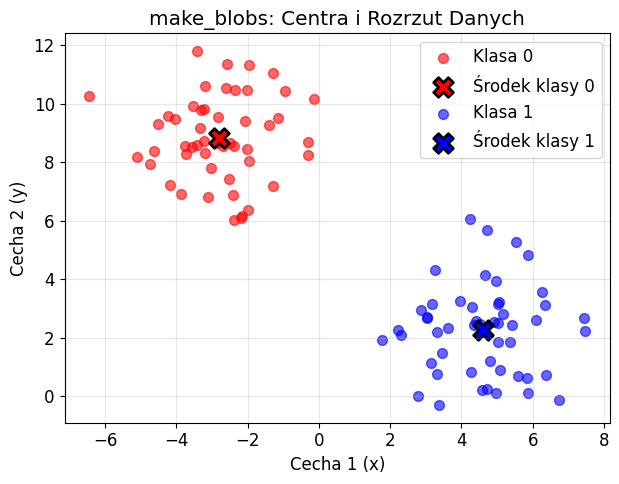

=== Analiza wygenerowanych danych ===
Klasa 0:
  Liczba punktów: 50
  Środek: (-2.80, 8.83)
  Odchylenie std: (1.25, 1.43)
Klasa 1:
  Liczba punktów: 50
  Środek: (4.59, 2.27)
  Odchylenie std: (1.31, 1.50)


In [5]:
plt.figure(figsize=(12, 5))


# Subplot 2: Analiza parametrów
plt.subplot(1, 2, 2)
colors = ['red', 'blue']
for i in range(2):
    class_data = X_linear[y_linear == i]
    plt.scatter(class_data[:, 0], class_data[:, 1], 
               c=colors[i], alpha=0.6, s=50, label=f'Klasa {i}')
    
    # Środek ciężkości każdej grupy
    center_x, center_y = np.mean(class_data, axis=0)
    plt.scatter(center_x, center_y, c=colors[i], s=200, 
               marker='X', edgecolors='black', linewidth=2,
               label=f'Środek klasy {i}')

plt.title('make_blobs: Centra i Rozrzut Danych')
plt.xlabel('Cecha 1 (x)')
plt.ylabel('Cecha 2 (y)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statystyki danych
print("=== Analiza wygenerowanych danych ===")
for i in range(2):
    class_data = X_linear[y_linear == i]
    print(f"Klasa {i}:")
    print(f"  Liczba punktów: {len(class_data)}")
    print(f"  Środek: ({np.mean(class_data, axis=0)[0]:.2f}, {np.mean(class_data, axis=0)[1]:.2f})")
    print(f"  Odchylenie std: ({np.std(class_data, axis=0)[0]:.2f}, {np.std(class_data, axis=0)[1]:.2f})")

In [6]:
svm_linear = svm.SVC(kernel='linear', C=1.0)
svm_linear.fit(X_train, y_train)

# Predykcje
y_pred = svm_linear.predict(X_test)

# Wyniki
print(f"Dokładność SVM liniowego: {accuracy_score(y_test, y_pred):.3f}")
print(f"Liczba wektorów nośnych: {svm_linear.n_support_}")
print(f"Całkowita liczba wektorów nośnych: {len(svm_linear.support_)}")

Dokładność SVM liniowego: 1.000
Liczba wektorów nośnych: [1 2]
Całkowita liczba wektorów nośnych: 3


 
### 🧮 **Kernel (jądro)**

Kernel decyduje, **w jaki sposób SVM przekształca dane wejściowe**, by móc znaleźć granicę między klasami.

* Dla danych **liniowo separowalnych** używa się `kernel='linear'`, czyli klasycznej prostej / płaszczyzny rozdzielającej.
* Dla danych **nieliniowych** (gdzie klasy nie da się oddzielić prostą) można użyć innych jąder:

| Kernel      | Opis                                              | Przykład zastosowania                                      |
| ----------- | ------------------------------------------------- | ---------------------------------------------------------- |
| `'linear'`  | Granica to prosta/płaszczyzna                     | Dane liniowo separowalne                                   |
| `'poly'`    | Wielomianowe przekształcenie cech                 | Dane z nieliniową granicą (np. okręgi)                     |
| `'rbf'`     | Radial Basis Function – „dzwonowa” funkcja Gaussa | Najczęściej używane, dobrze działa dla nieliniowych danych |
| `'sigmoid'` | Używa funkcji sigmoidalnej (jak w neuronach)      | Rzadziej stosowane, podobne do sieci neuronowych           |

---

### ⚖️ **Parametr `C`**

To **współczynnik kary za błędną klasyfikację** — reguluje kompromis między **szerokością marginesu** a **dokładnością klasyfikacji**:

* **Duże `C`** → model „stara się” klasyfikować wszystko poprawnie (węższy margines, ryzyko przeuczenia).
* **Małe `C`** → model dopuszcza błędy, ale ma **szerszy margines** i lepszą generalizację.

---



### 🔹 Co tu się dzieje:

* **`svm.SVC(kernel='linear')`** — tworzy liniowy klasyfikator SVM, który szuka prostej (lub płaszczyzny) oddzielającej klasy.  
* **`fit()`** — uczy model na danych treningowych.  
* **`predict()`** — przewiduje etykiety dla danych testowych.  
* **`accuracy_score(y_test, y_pred)`** — liczy **dokładność**, czyli:  

  $$ 
  \text{Accuracy} = \frac{\text{liczba poprawnych przewidywań}}{\text{liczba wszystkich próbek}}
  $$  

  np. `0.93` oznacza, że model poprawnie rozpoznał **93% przykładów**.

---

### 🔹 Wektory nośne:

* **`svm_linear.n_support_`** — ile wektorów nośnych przypada na każdą klasę,  
* **`len(svm_linear.support_)`** — całkowita liczba wektorów nośnych (punktów leżących najbliżej granicy decyzyjnej).


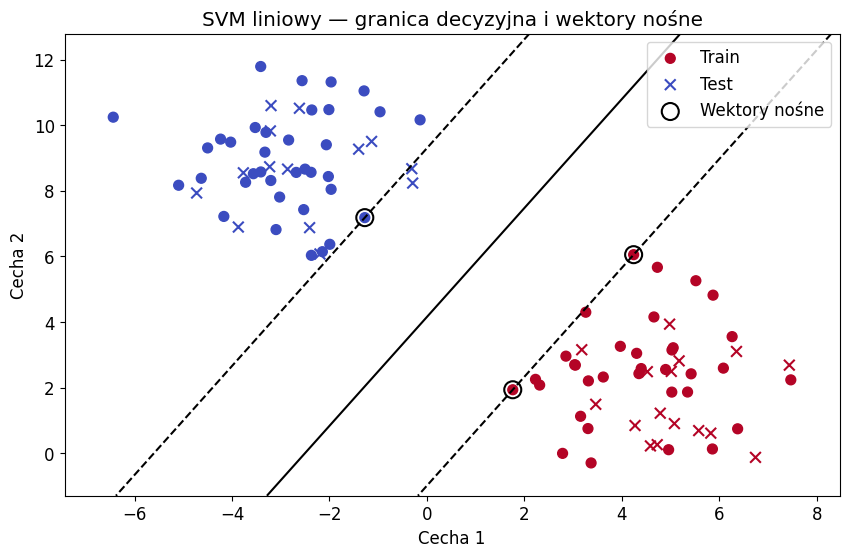

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Dane
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=42, cluster_std=1.5)

# Podział na zbiory
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model SVM liniowy
svm_linear = svm.SVC(kernel='linear', C=1.0, random_state=42)
svm_linear.fit(X_train, y_train)

# Parametry prostej decyzyjnej
w = svm_linear.coef_[0]
b = svm_linear.intercept_[0]

# Siatka punktów do wizualizacji
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z = svm_linear.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Wykres
plt.figure(figsize=(10, 6))
# Punkty danych
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=50, label="Train")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, marker='x', s=60, label="Test")

# Hiperpłaszczyzna i marginesy
plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')

# Wektory nośne
plt.scatter(svm_linear.support_vectors_[:, 0], svm_linear.support_vectors_[:, 1],
            s=150, facecolors='none', edgecolors='k', linewidths=1.5, label='Wektory nośne')

plt.title("SVM liniowy — granica decyzyjna i wektory nośne")
plt.xlabel("Cecha 1")
plt.ylabel("Cecha 2")
plt.legend()
plt.show()


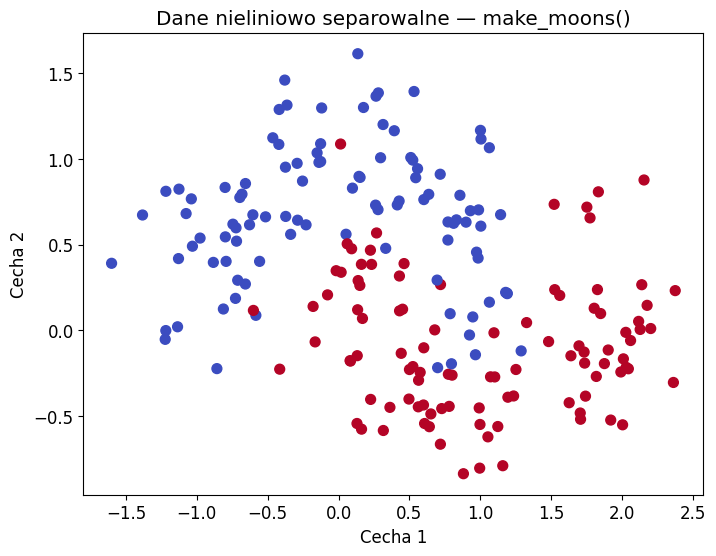

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Tworzymy dane — dwa półksiężyce (nieliniowo separowalne)
X, y = make_moons(n_samples=200, noise=0.25, random_state=42)

# Podział na zbiory
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Wizualizacja
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=50)
plt.title("Dane nieliniowo separowalne — make_moons()")
plt.xlabel("Cecha 1")
plt.ylabel("Cecha 2")
plt.show()


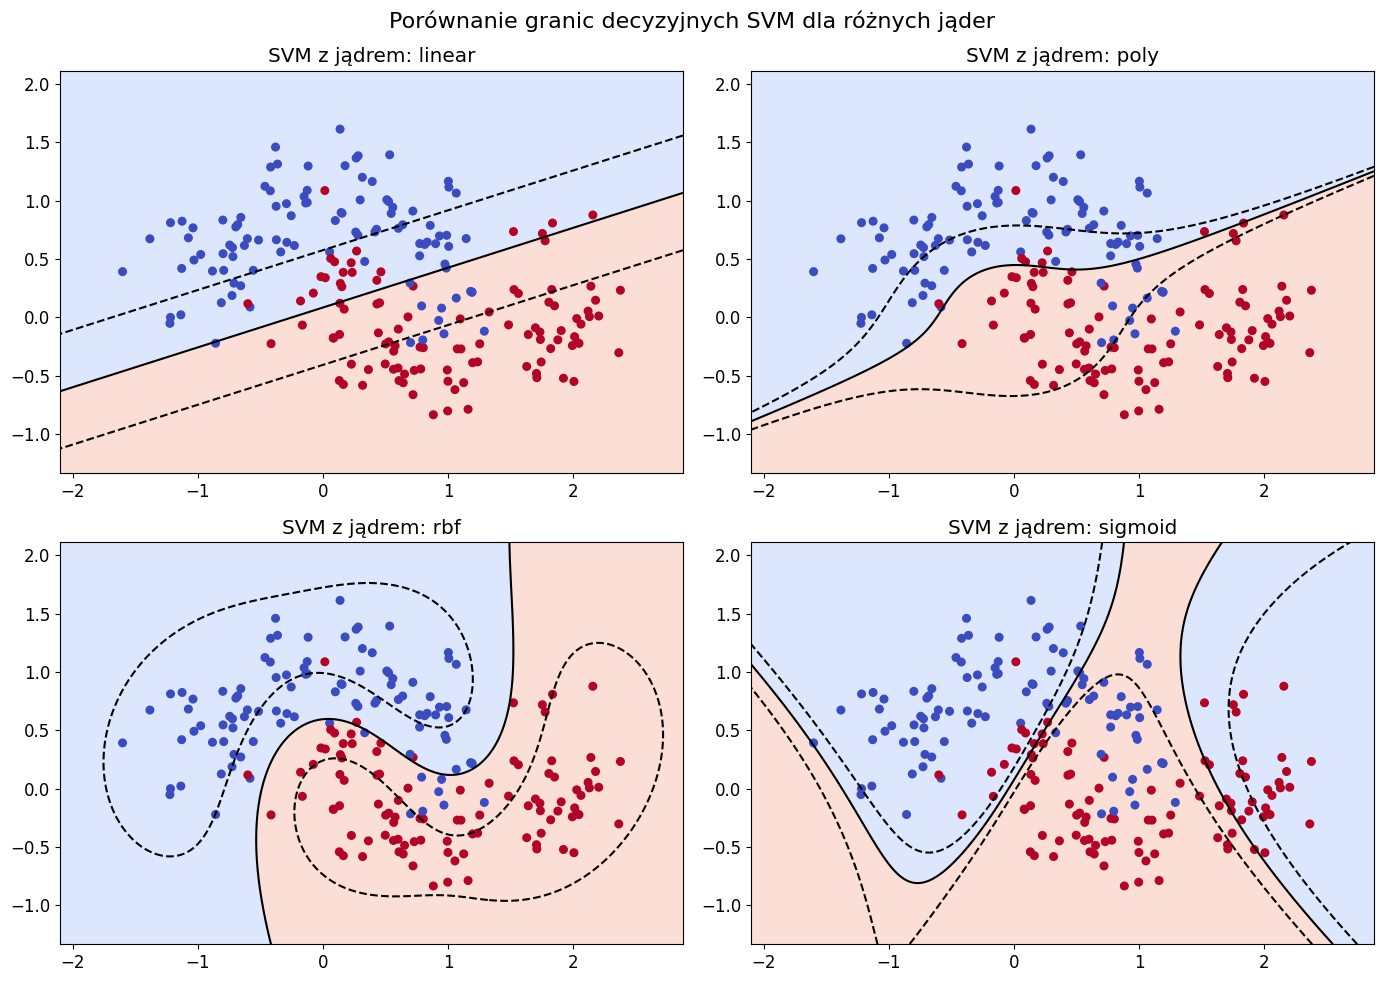

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Dane nieliniowo separowalne
X, y = make_moons(n_samples=200, noise=0.25, random_state=42)

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Różne jądra do porównania
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

plt.figure(figsize=(14, 10))

for i, kernel in enumerate(kernels, 1):
    model = svm.SVC(kernel=kernel, C=1.0, gamma='scale')
    model.fit(X_train, y_train)
    
    # Siatka do wizualizacji
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Wykres
    plt.subplot(2, 2, i)
    plt.contourf(xx, yy, Z > 0, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=30)
    plt.title(f"SVM z jądrem: {kernel}")

plt.suptitle("Porównanie granic decyzyjnych SVM dla różnych jąder", fontsize=16)
plt.tight_layout()
plt.show()


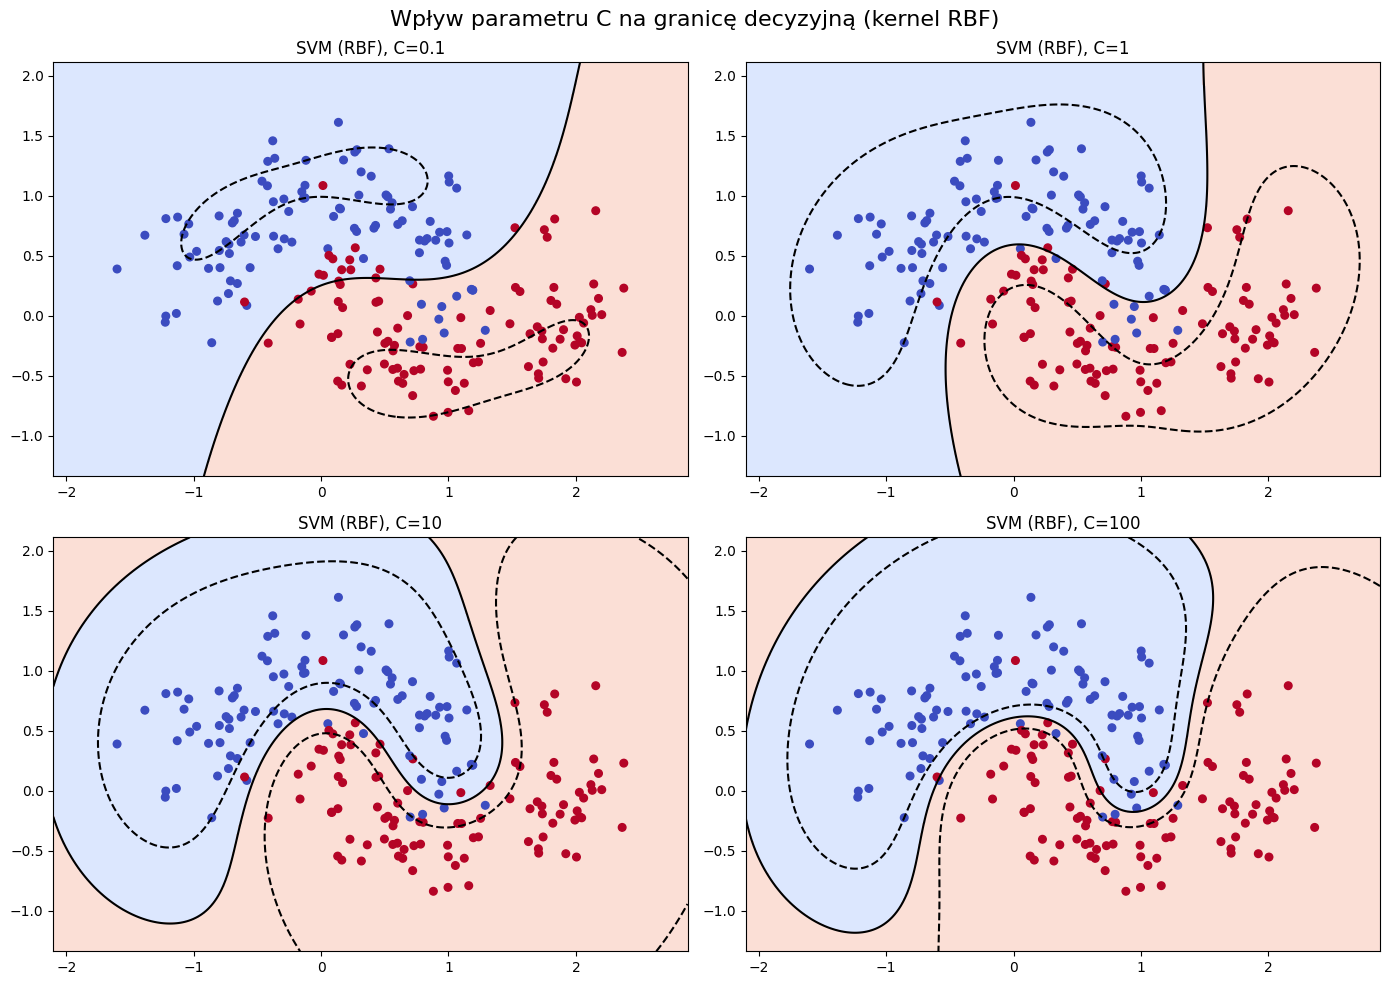

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Dane nieliniowo separowalne
X, y = make_moons(n_samples=200, noise=0.25, random_state=42)

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Różne wartości C
C_values = [0.1, 1, 10, 100]

plt.figure(figsize=(14, 10))

for i, C in enumerate(C_values, 1):
    model = svm.SVC(kernel='rbf', C=C, gamma='scale')
    model.fit(X_train, y_train)
    
    # Siatka do wizualizacji
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Wykres
    plt.subplot(2, 2, i)
    plt.contourf(xx, yy, Z > 0, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=30)
    plt.title(f"SVM (RBF), C={C}")

plt.suptitle("Wpływ parametru C na granicę decyzyjną (kernel RBF)", fontsize=16)
plt.tight_layout()
plt.show()


### 🧩 Interpretacja wpływu parametru **C** w SVM (dla jądra RBF)

Parametr **`C`** kontroluje kompromis między **prostotą modelu** a **dokładnym dopasowaniem do danych**.
Zmieniając jego wartość, wpływasz bezpośrednio na **szerokość marginesu decyzyjnego** oraz **kształt granicy między klasami**.

---

#### 🔹 **C = 0.1**

* Model jest **bardzo „miękki”** – dopuszcza błędy klasyfikacji.
* Granica decyzyjna jest **gładka, szeroka i uproszczona**, często nie odwzorowuje dokładnie kształtu danych.
* Model **generalizuje dobrze**, ale może **niedouczyć się** danych.

---

#### 🔹 **C = 1**

* Umiarkowany kompromis między dokładnością a prostotą.
* Granica dopasowuje się do danych, ale nadal jest względnie gładka.
* To zwykle **najlepszy punkt wyjścia** — model dobrze rozdziela klasy bez przeuczenia.

---

#### 🔹 **C = 10**

* Model staje się bardziej „sztywny”.
* Granica decyzyjna **ściśle dopasowuje się** do kształtu półksiężyców.
* Dokładność rośnie, ale margines staje się węższy — model zaczyna być **mniej odporny na szum**.

---

#### 🔹 **C = 100**

* Model próbuje **idealnie dopasować każdy punkt treningowy**.
* Granica decyzyjna jest **poszarpana i niestabilna**, wrażliwa na nawet minimalne zmiany danych.
* Wysoka dokładność na treningu, ale **duże ryzyko przeuczenia** (słabsze wyniki na danych testowych).

---

### 🧠 Podsumowanie

| Wartość `C`         | Margines     | Dopasowanie  | Ryzyko przeuczenia |
| ------------------- | ------------ | ------------ | ------------------ |
| **Małe (`0.1`)**    | szeroki      | słabe        | niskie             |
| **Średnie (`1`)**   | zbalansowany | dobre        | umiarkowane        |
| **Duże (`10–100`)** | wąski        | bardzo dobre | wysokie            |

---

➡️ W skrócie:

* **Małe `C`** = model prostszy, stabilny, ale mniej dokładny.
* **Duże `C`** = model dopasowany, ale może się przeuczyć.
* Najlepsze wyniki zwykle daje **wartość pośrednia (`C ≈ 1`)**, zależnie od danych i poziomu szumu.


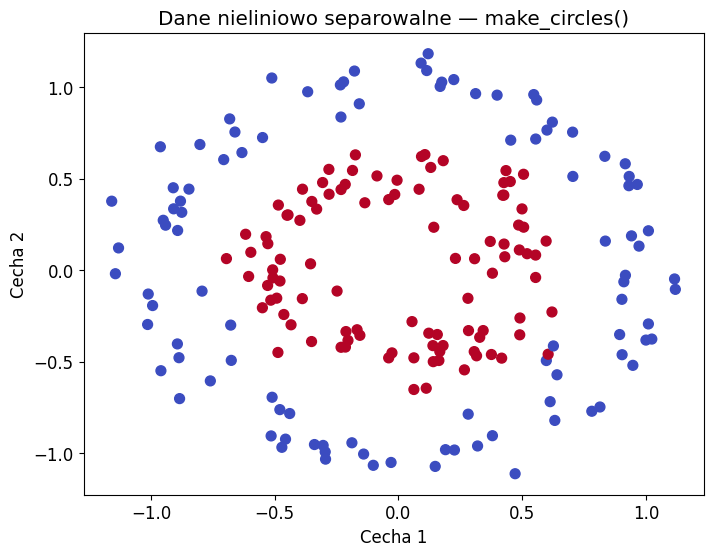

In [11]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=200, noise=0.1, factor=0.5, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=50)
plt.title("Dane nieliniowo separowalne — make_circles()")
plt.xlabel("Cecha 1")
plt.ylabel("Cecha 2")
plt.show()


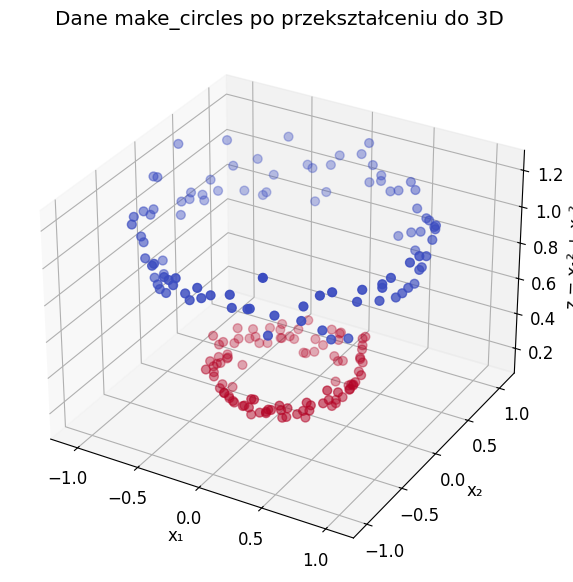

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_circles

# Dane 2D
X, y = make_circles(n_samples=200, noise=0.05, factor=0.5, random_state=42)

# Dodajemy trzeci wymiar: z = x1² + x2²
X1, X2 = X[:, 0], X[:, 1]
Z = X1**2 + X2**2

# Wykres 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Punkty 3D
ax.scatter(X1, X2, Z, c=y, cmap=plt.cm.coolwarm, s=40)

ax.set_xlabel("x₁")
ax.set_ylabel("x₂")
ax.set_zlabel("z = x₁² + x₂²")
ax.set_title("Dane make_circles po przekształceniu do 3D")

plt.show()


 
---

### 🧩 Co się tutaj zadziało — intuicja działania *kernel trick* na przykładzie `make_circles()`

---

#### 🌀 **1️⃣ Dane początkowe — nieliniowo separowalne w 2D**

Zbiór danych wygenerowany funkcją `make_circles()` tworzy **dwa koncentryczne okręgi**:

* punkty jednej klasy znajdują się **wewnątrz**,
* punkty drugiej klasy tworzą **pierścień na zewnątrz**.

W tej płaskiej przestrzeni 2D **nie istnieje prosta**, która oddziela obie klasy —
czyli problem jest **nieliniowo separowalny**.

---

#### 🔼 **2️⃣ Dodanie nowej cechy**

Dodajemy trzeci wymiar:

$$
z = x_1^2 + x_2^2
$$

Ta transformacja odpowiada **kwadratowi odległości punktu od środka układu**.
W wyniku tego:

* punkty bliżej środka (wewnętrzny okrąg) mają **mniejszą wartość** ( z ),
* punkty z zewnętrznego okręgu mają **większą wartość** ( z ).

---

#### 🧭 **3️⃣ Wizualizacja w przestrzeni 3D**

Po przekształceniu dane układają się w coś na kształt **miski (paraboloidy)**:

* punkty jednej klasy są „niżej”,
* drugiej — „wyżej”.

Teraz można **narysować płaszczyznę poziomą**, która **liniowo rozdziela klasy** w tej nowej przestrzeni.

Czyli po dodaniu wymiaru ( z ) dane stają się **liniowo separowalne**.

---

#### ⚙️ **4️⃣ Co robi kernel (jądro) w SVM**

SVM nie wykonuje tej transformacji wprost.
Zamiast tego używa **funkcji jądra**, np. jądra RBF:

$$
K(x, x') = \exp(-\gamma |x - x'|^2)
$$

Ta funkcja **oblicza podobieństwo punktów tak, jakby dane były przeniesione do wyższej przestrzeni**,
ale robi to **bez faktycznego przekształcania danych** (to właśnie „kernel trick”).

Dzięki temu SVM może znaleźć **płaską granicę w przestrzeni wysokiego wymiaru**,
która po rzutowaniu z powrotem do 2D wygląda jak **krzywa (np. okrąg)**.

---

#### 🎯 **5️⃣ Podsumowanie**

| Przestrzeń                            | Kształt granicy | Separacja    |
| ------------------------------------- | --------------- | ------------ |
| 2D (oryginalna)                       | okrąg           | ❌ nieliniowa |
| 3D (po dodaniu $( z = x_1^2 + x_2^2 ))$ | płaszczyzna     | ✅ liniowa    |

---

➡️ **Wniosek:**
Dzięki zastosowaniu *kernel trick*, SVM potrafi rozwiązywać **problemy nieliniowe**
przez „ukryte” przekształcenie danych do wyższego wymiaru,
gdzie granica decyzyjna staje się liniowa.

https://www.youtube.com/watch?v=Q7vT0--5VII



### ⚙️ Parametr `gamma` w SVM (dla jąder nieliniowych)

* **`gamma`** kontroluje, jak daleko sięga wpływ pojedynczego punktu treningowego.

  * Mała γ → granica **gładka**, szeroka (model uogólnia).
  * Duża γ → granica **poszarpana**, dopasowana (model może się przeuczyć).

---

### 🧮 Wartości `gamma` w `sklearn.SVC`:

| Ustawienie       | Wzór                                                           | Znaczenie                              | Zalecenie             |
| ---------------- | -------------------------------------------------------------- | -------------------------------------- | --------------------- |
| `gamma='scale'`  | $( \gamma = \frac{1}{n_{\text{features}} \cdot \text{Var}(X)} )$ | automatycznie dopasowuje się do danych | ✅ domyślne, najlepsze |
| `gamma='auto'`   | $( \gamma = \frac{1}{n_{\text{features}}} )$                     | ignoruje skalę danych                  | ⚠️ przestarzałe       |
| `gamma = liczba` | —                                                              | ręczne ustawienie (np. 0.1, 1, 10)     | 🔧 do eksperymentów   |

---

> 🔹 W skrócie:
> `gamma='scale'` = automatyczna, bezpieczna wartość dopasowana do rozrzutu danych.
> Dzięki temu granica decyzyjna ma sensowny kształt bez ręcznego strojenia.


Dokładność: 0.933

Raport klasyfikacji:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        40
           1       0.88      0.92      0.90        25
           2       1.00      0.96      0.98        25

    accuracy                           0.93        90
   macro avg       0.94      0.94      0.94        90
weighted avg       0.93      0.93      0.93        90



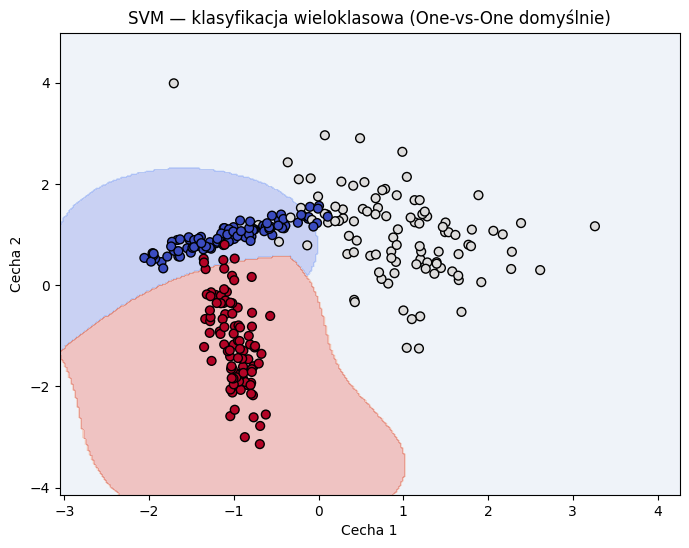

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Tworzymy dane z 3 klasami
X, y = make_classification(
    n_samples=300, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_clusters_per_class=1,
    n_classes=3, 
    random_state=42
)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Klasyfikator SVM z jądrem RBF (domyślnie OvO)
model = svm.SVC(kernel='rbf', C=1.0, gamma='scale')
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wyniki
print(f"Dokładność: {accuracy_score(y_test, y_pred):.3f}")
print("\nRaport klasyfikacji:\n")
print(classification_report(y_test, y_pred))

# Wizualizacja granic decyzyjnych
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=40, edgecolors='k')
plt.title("SVM — klasyfikacja wieloklasowa (One-vs-One domyślnie)")
plt.xlabel("Cecha 1")
plt.ylabel("Cecha 2")
plt.show()




### ⚙️ Systemy wieloklasowe w SVM: *One-vs-Rest* i *One-vs-One*

SVM z natury jest algorytmem **binarnym** — rozdziela tylko **dwie klasy**.
Gdy mamy więcej klas (np. 3, 4, 5...), stosuje się jedną z dwóch strategii:

---

#### 🔹 **One-vs-Rest (OvR)** – *jeden kontra reszta*

* Dla każdej klasy budowany jest **jeden klasyfikator**, który odróżnia tę klasę od wszystkich pozostałych.
* Jeśli masz ( K ) klas → powstaje ( K ) modeli.
* Podczas predykcji wybierana jest klasa z **największym wynikiem decyzyjnym**.

**Zalety:** szybki, prostszy, wymaga mniej modeli.
**Wady:** może gorzej działać, gdy klasy są silnie nakładające się.

---

#### 🔹 **One-vs-One (OvO)** – *jeden kontra jeden*

* Tworzy się osobny klasyfikator **dla każdej pary klas**.
* Jeśli masz ( K ) klas → powstaje $( \frac{K(K-1)}{2} )$ modeli.
* Każdy model głosuje na jedną z dwóch klas, a końcowy wynik to **klasa z największą liczbą głosów**.

**Zalety:** bardzo dokładny, szczególnie gdy klasy dobrze się rozdzielają.
**Wady:** więcej modeli = większa złożoność obliczeniowa.

---

#### 🧠 **W sklearn:**

* Dla `SVC` domyślnie używany jest **One-vs-One (OvO)**.
* Dla `LinearSVC` (wersja liniowa, szybsza) domyślnie używany jest **One-vs-Rest (OvR)**.

---

> 💡 **Podsumowanie:**
>
> * `OvR` → prostszy, szybszy, jeden model na klasę.
> * `OvO` → dokładniejszy, ale wolniejszy, wiele modeli.
> * W `scikit-learn` możesz wybrać ręcznie:
>
>   ```python
>   from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
>   ```


=== One-vs-Rest (OvR) ===
Dokładność: 0.933
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        30
           1       0.96      0.90      0.93        30
           2       1.00      0.93      0.97        30

    accuracy                           0.93        90
   macro avg       0.94      0.93      0.93        90
weighted avg       0.94      0.93      0.93        90


=== One-vs-One (OvO) ===
Dokładność: 0.933
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        30
           1       0.96      0.90      0.93        30
           2       1.00      0.93      0.97        30

    accuracy                           0.93        90
   macro avg       0.94      0.93      0.93        90
weighted avg       0.94      0.93      0.93        90



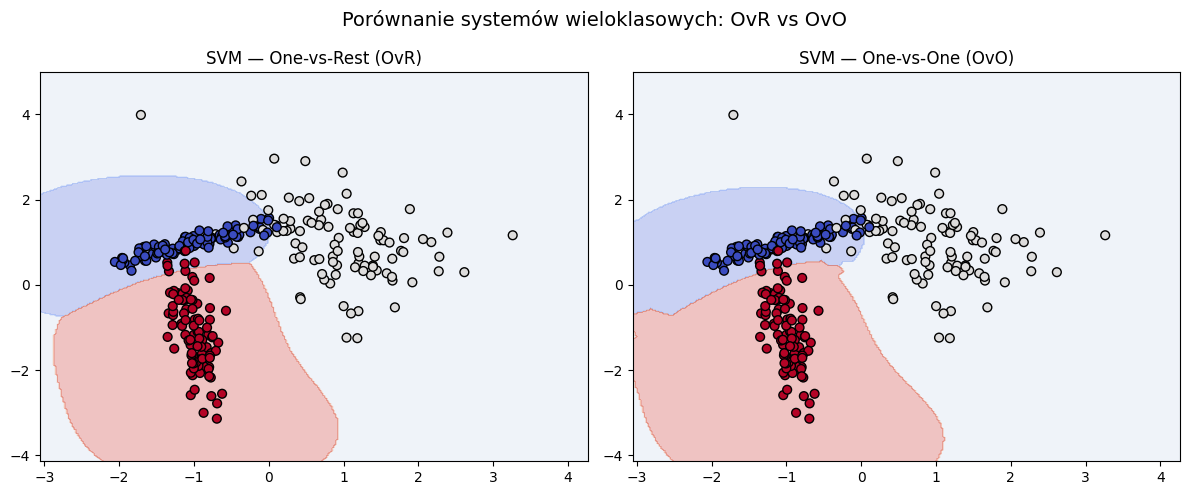

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

# === 1️⃣ Generowanie danych ===
X, y = make_classification(
    n_samples=300, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_clusters_per_class=1,
    n_classes=3, 
    random_state=42
)

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# === 2️⃣ Modele ===
ovr_model = OneVsRestClassifier(svm.SVC(kernel='rbf', C=1.0, gamma='scale'))
ovo_model = OneVsOneClassifier(svm.SVC(kernel='rbf', C=1.0, gamma='scale'))

ovr_model.fit(X_train, y_train)
ovo_model.fit(X_train, y_train)

# === 3️⃣ Predykcje ===
y_pred_ovr = ovr_model.predict(X_test)
y_pred_ovo = ovo_model.predict(X_test)

# === 4️⃣ Wyniki ===
print("=== One-vs-Rest (OvR) ===")
print(f"Dokładność: {accuracy_score(y_test, y_pred_ovr):.3f}")
print(classification_report(y_test, y_pred_ovr))

print("\n=== One-vs-One (OvO) ===")
print(f"Dokładność: {accuracy_score(y_test, y_pred_ovo):.3f}")
print(classification_report(y_test, y_pred_ovo))

# === 5️⃣ Wizualizacja granic decyzyjnych ===
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

Z_ovr = ovr_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z_ovo = ovo_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(12, 5))

# OvR
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z_ovr, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', s=40)
plt.title("SVM — One-vs-Rest (OvR)")

# OvO
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z_ovo, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', s=40)
plt.title("SVM — One-vs-One (OvO)")

plt.suptitle("Porównanie systemów wieloklasowych: OvR vs OvO", fontsize=14)
plt.tight_layout()
plt.show()
